In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box

from waterlagen import datastore
from waterlagen.ahn.download import get_ahn_rasters
from waterlagen.ahn.interpolate import interpolate_ahn_tiles
from waterlagen.bag.download import get_bag_features
from waterlagen.bag.rasterize import rasterize_bag
from waterlagen.logger import init_logger
from waterlagen.raster import create_vrt_file

## Aanpak
We gaan een DEM maken voor een klein stukje Alkmaar in de volgende stappen:
1. Downloaden AHN
2. Downloaden BAG
3. Dichtinterpoleren AHN
4. Rasterizeren BAG op basis van het AHN uit stap 1

Hieronder specificeren we de logger; die schrijft direct een logfile in de DataStore

In [8]:
name = "dem_alkmaar"
logger = init_logger(name=name, log_file=datastore.data_dir / f"{name}.log")

bbox = [110960, 515600, 112560, 516760]
poly_mask = box(*bbox)
gpd.GeoSeries([poly_mask], crs=28992).explore()

## Downloaden AHN

In [9]:
ahn_vrt = get_ahn_rasters(poly_mask=poly_mask)

## Downloaden BAG

In [10]:
bag_gdf = get_bag_features(bbox, layer="pand", source="wfs")

INFO waterlagen.bag.download: Start downloading BAG bag:pand using WFS, 1000 features per page (download)


## Dichtinterpoleren AHN

In [ ]:
ahn_filled_vrt = interpolate_ahn_tiles(ahn_vrt_file=ahn_vrt)

INFO waterlagen.ahn.interpolate: start interpolating M_19BZ1 (1/1)
INFO waterlagen.ahn.interpolate: writing d:\repositories\waterlagen\docs\notebooks\data\processed_data\ahn_filled\M_19BZ1.tif
INFO waterlagen.raster: VRT file created d:\repositories\waterlagen\docs\notebooks\data\processed_data\ahn_filled\ahn_filled.vrt


## Verrasteren vloerpeilen

In [12]:
out_tif = datastore.processed_data_dir / "bag_pand.tif"
rasterize_bag(
    dem_raster=ahn_filled_vrt,
    bag_gdf=bag_gdf,
    bag_pand_tif=out_tif,
    buffer_step_m=1,
)

# Samenvoegen DTM + BAG tot 1 VRT

INFO waterlagen.raster: VRT file created d:\repositories\waterlagen\docs\notebooks\data\processed_data\dem.vrt


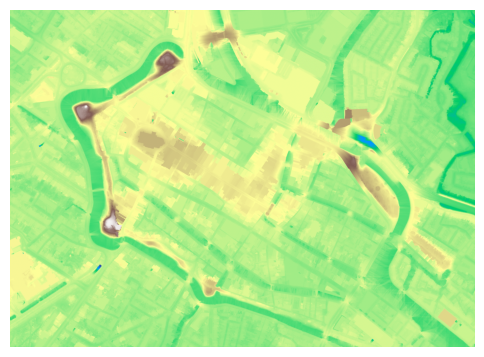

In [26]:
dem_vrt = datastore.processed_data_dir / "dem.vrt"
dem_vrt = create_vrt_file(
    vrt_file=dem_vrt,
    directory=[
        ahn_filled_vrt.parent,
        datastore.processed_data_dir,
    ],
)


with rasterio.open(dem_vrt) as src:
    window = from_bounds(*bbox, transform=src.transform)
    data = src.read(1, window=window, masked=True)
    transform = src.window_transform(window)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(
    data,
    extent=(bbox[0], bbox[2], bbox[1], bbox[3]),
    origin="upper",
    cmap="terrain",
)
plt.axis("off")
plt.show()